## Evaluation of name onomastics

We use Namsor's origin and diaspora APIs to explore the origin of names in our dataset and evaluate the potential bias of the data set and the services in the benchmark.

In [1]:
import requests
import json
from pandas.io.json import json_normalize
import pandas as pd
from collections import OrderedDict
import urllib
from os.path import join

import matplotlib.pyplot as plt
#plt.style.use('ggplot')


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
from config import NAMSOR_USER, NAMSOR_PW

headers = {
    'X-Channel-Secret': NAMSOR_PW,
    'X-Channel-User': NAMSOR_USER,
    'Accept': 'application/json',
}

In [5]:
# testing
response = requests.get('https://api.namsor.com/onomastics/api/json/origin/Caitriona/Kennedy', headers=headers)
response.text

'{"country":"IE","countryAlt":"GB","score":3.6568307047142934,"script":"LATIN","countryFirstName":"IE","countryLastName":"GB","scoreFirstName":2.373716624391118,"scoreLastName":2.53655126308492,"subRegion":"Northern Europe","region":"Europe","topRegion":"Europe","countryName":"Ireland"}'

In [ ]:
response.status_code

In [30]:
# Test how API reacts to usage of hyphens
response = requests.get('https://api.namsor.com/onomastics/api/json/origin/sheau-chiou/chao', headers=headers)
response.text

'{"country":"CN","countryAlt":"CN","score":3.327766060755152,"script":"LATIN","countryFirstName":"TW","countryLastName":"TW","scoreFirstName":-0.023863777936456505,"scoreLastName":2.531070718432645,"subRegion":"Eastern Asia","region":"Asia","topRegion":"Asia","countryName":"China"}'

In [31]:
# Test how API reacts to usage of spaces
response = requests.get('https://api.namsor.com/onomastics/api/json/origin/sheau chiou/chao', headers=headers)
response.text

In [57]:
# test usage of diacritics
response = requests.get('https://api.namsor.com/onomastics/api/json/origin/marià/misić', 
                        headers=headers)
response.text

'{"country":"RS","countryAlt":"RS","score":-0.3349759457401318,"script":"LATIN","countryFirstName":"ES","countryLastName":"RS","scoreFirstName":-0.14794969736484045,"scoreLastName":0.3992291149412908,"subRegion":"Southern Europe","region":"Europe","topRegion":"Europe","countryName":"Serbia"}'

### Read data file with all names

In [5]:
data = pd.read_csv('../test_data/raw_data/all.csv', keep_default_na=False)

In [6]:
data.shape

(7076, 6)

In [7]:
data.sample(3)

,first_name,middle_name,last_name,full_name,gender,origin
4659,virginia,,belloni,virginia belloni,f,wos
2837,xian,,qi,xian qi,m,pubmed
4954,zi,yun,shi,zi yun shi,f,wos


###  Fetch origin predictions

In [71]:
origin = []
origin_url = 'https://api.namsor.com/onomastics/api/json/origin/'
for i, row in data.iterrows():
    if row['middle_name'] == '':
        url = origin_url + row['first_name'] + '/' + row['last_name']
    else:
        url = origin_url + row['first_name'] + '-' + row['middle_name'] + '/' + row['last_name']
    r = requests.get(url, headers=headers)
    if r.status_code == 200:
        origin.append(json.loads(r.text))
    else:
        print(row)
        origin.append({})

In [73]:
len(origin)

7076

In [74]:
origin_df = json_normalize(origin)

In [43]:
origin_df['full_name'] = data['full_name']
origin_df['gender'] = data['gender']
origin_df['source'] = data['origin']

In [48]:
origin_df.sample(3)

,country,countryAlt,countryFirstName,countryLastName,countryName,region,score,scoreFirstName,scoreLastName,script,subRegion,topRegion,full_name,gender,source
5901,IE,LR,IE,GB,Ireland,Europe,2.969702,2.701208,1.029097,LATIN,Northern Europe,Europe,timothy farley,u,wos
887,GB,GB,UG,GB,United Kingdom of Great Britain and Northern I...,Europe,1.936933,2.020439,1.319162,LATIN,Northern Europe,Europe,patricia clee,u,genderize_r_authors
1843,DE,DE,UG,DE,Germany,Europe,3.170821,1.228249,2.983891,LATIN,Western Europe,Europe,allen dietrich,m,pubmed


In [44]:
origin_df.to_csv("origin_evaluation.csv", sep=';', index=False)

In [3]:
origin_df = pd.read_csv("origin_evaluation.csv", sep=';')

In [4]:
origin_df = origin_df[['full_name', 'gender', 'source', 'countryName', 'country', 'countryAlt', 
                       'region', 'subRegion', 'topRegion', 'score']]

origin_df = origin_df.rename({'score': 'score_origin'}, axis='columns')

In [5]:
origin_df.sample(3)

,full_name,gender,source,countryName,country,countryAlt,region,subRegion,topRegion,score_origin
6164,dominique massey-harroche,f,wos,France,FR,BE,Europe,Western Europe,Europe,1.486240
633,adam lashinsky,m,genderize_r_authors,Poland,PL,CZ,Europe,Eastern Europe,Europe,2.016444
4287,cara williams,f,wos,United Kingdom of Great Britain and Northern I...,GB,NG,Europe,Northern Europe,Europe,1.649431


### Analysis

In [90]:
origin_df.topRegion.value_counts()

Europe      4338
Asia        2372
Africa       365
Americas       1
Name: topRegion, dtype: int64

In [91]:
len(origin_df[origin_df.score_origin <= 0])

210

Referring to Namsor's evaluations, scores above 0 are reliable for Europe, Asia and Africa. Hence the classification for almost all names in our data set is reliable.

In [92]:
# check whether a data source is particularly affected by the low origin score
count_low_score = origin_df[origin_df.score_origin <= 0].groupby('source')['full_name'].count()
count_all = origin_df.groupby('source')['full_name'].count()
count_low_score.divide(count_all)

source
genderize_r_authors    0.031746
genderize_r_titles     0.036170
pubmed                 0.025615
wos                    0.032547
zbmath                 0.012500
Name: full_name, dtype: float64

The source `zbmath` is least affected by low scores but the difference is not significant (1-3%).

In [93]:
origin_df[origin_df.score_origin > 0].topRegion.value_counts()

Europe    4228
Asia      2304
Africa     334
Name: topRegion, dtype: int64

#### Distribution of regions by data source

In [8]:
origin_by_source = origin_df[origin_df.score_origin > 0].groupby(['topRegion', 'source']).count().\
unstack('topRegion')['full_name'].fillna(0)
origin_by_source

topRegion,Africa,Asia,Europe
source,,,
genderize_r_authors,35,58,456
genderize_r_titles,27,50,376
pubmed,108,462,1332
wos,149,1609,1809
zbmath,15,125,255


In [9]:
# normalize
origin_by_source['sum'] = [origin_by_source.loc[i,:].sum() for i in origin_by_source.index]
origin_by_source = origin_by_source.apply(lambda x: x/x['sum'], axis=1)

In [10]:
origin_by_source

topRegion,Africa,Asia,Europe,sum
source,,,,
genderize_r_authors,0.063752,0.105647,0.830601,1.0
genderize_r_titles,0.059603,0.110375,0.830022,1.0
pubmed,0.056782,0.242902,0.700315,1.0
wos,0.041772,0.451079,0.507149,1.0
zbmath,0.037975,0.316456,0.645570,1.0


In [11]:
origin_by_source = origin_by_source[['Europe', 'Asia', 'Africa']]

In [12]:
origin_by_source.index.name = None
origin_by_source.columns.name = 'Region'

In [13]:
origin_by_source

Region,Europe,Asia,Africa
genderize_r_authors,0.830601,0.105647,0.063752
genderize_r_titles,0.830022,0.110375,0.059603
pubmed,0.700315,0.242902,0.056782
wos,0.507149,0.451079,0.041772
zbmath,0.645570,0.316456,0.037975


In [14]:
# map service names for print
gender_evalautor_to_service_name = {'gender_api': 'Gender API', 'gender_guesser': 'gender-guesser', 
                                    'genderize_io': 'genderize.io', 'name_api_full': 'NameAPI', 'namsor': 'NamSor'}

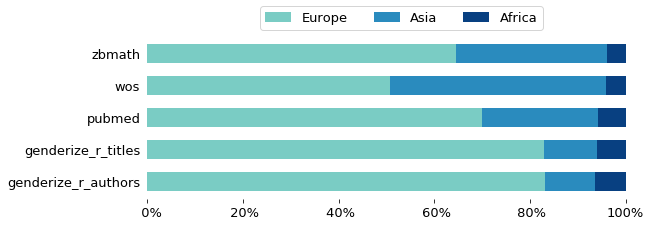

In [15]:
matplotlib.rcParams.update({'font.size': 13})

fig, ax = plt.subplots(figsize=(9,3))

colors = plt.cm.GnBu(np.linspace(0.5, 1, 3))

origin_by_source.plot(ax=ax, kind='barh', stacked=True, width=0.6, color=colors)

vals = ax.get_xticks()
ax.set_xticklabels(['{:3.0f}%'.format(x*100) for x in vals]);

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.legend(ncol=3, bbox_to_anchor=(0.8, 1.22));

ax.yaxis.set_ticks_position('none') 

# Make sure that benchmark_paper and name_gender_inference repos are on the same directory level
# This saves the fig directly into the paper directory
plt.savefig('../../../benchmark_paper/resubmission/names_regions.pdf', bbox_inches = 'tight')

* all data sources show only a few percent of African names. 
* For `wos` approximately half of the names are from Asia and the other half have European origin; for the other data sources, names of European origin predominate, in particular for the `genderize_r` data sources 

#### Distribution of countries by data source

In [102]:
origin_by_source = origin_df[origin_df.score_origin > 0].groupby(['countryName', 'source']).count().\
unstack('countryName')['full_name'].fillna(0)
# normalize
origin_by_source['sum'] = [origin_by_source.loc[i,:].sum() for i in origin_by_source.index]
origin_by_source = origin_by_source.apply(lambda x: x/x['sum'], axis=1)
origin_by_source = origin_by_source.drop(['sum'], axis=1)

In [103]:
origin_by_source

countryName,Afghanistan,Albania,Algeria,Armenia,Austria,Azerbaijan,Bahrain,Bangladesh,Belarus,Belgium,...,Turkey,Uganda,Ukraine,United Arab Emirates,United Kingdom of Great Britain and Northern Ireland,Uzbekistan,Viet Nam,Yemen,Zambia,Zimbabwe
source,,,,,,,,,,,,,,,,,,,,,
genderize_r_authors,0.000000,0.000000,0.001821,0.001821,0.041894,0.00000,0.000000,0.001821,0.001821,0.007286,...,0.009107,0.000000,0.000000,0.000000,0.222222,0.001821,0.000000,0.000000,0.000000,0.001821
genderize_r_titles,0.000000,0.000000,0.000000,0.000000,0.024283,0.00000,0.000000,0.000000,0.000000,0.006623,...,0.000000,0.006623,0.002208,0.000000,0.264901,0.002208,0.000000,0.000000,0.000000,0.000000
pubmed,0.000526,0.001052,0.001052,0.002629,0.024185,0.00000,0.000526,0.004732,0.001052,0.013670,...,0.004206,0.004732,0.002103,0.000000,0.187697,0.000526,0.001577,0.000000,0.000000,0.000000
wos,0.001121,0.000561,0.001121,0.001402,0.015980,0.00028,0.000841,0.005607,0.001121,0.011214,...,0.026072,0.001121,0.001402,0.000561,0.089711,0.000280,0.005046,0.001402,0.001121,0.000280
zbmath,0.000000,0.000000,0.007595,0.000000,0.017722,0.00000,0.000000,0.002532,0.002532,0.005063,...,0.025316,0.000000,0.010127,0.000000,0.068354,0.000000,0.002532,0.005063,0.000000,0.000000


In [104]:
# print the most frequent countries per data source and their cummulative sum
no_countries = 10
for i, row in origin_by_source.iterrows():
    print("data source: ", i)
    row_sorted = row.sort_values(ascending=False)
    print(row_sorted[:no_countries].cumsum(axis=0))


data source:  genderize_r_authors
countryName
United Kingdom of Great Britain and Northern Ireland    0.222222
Ireland                                                 0.369763
Germany                                                 0.495446
Italy                                                   0.542805
France                                                  0.586521
Austria                                                 0.628415
Poland                                                  0.664845
Israel                                                  0.692168
India                                                   0.717668
Spain                                                   0.743169
Name: genderize_r_authors, dtype: float64
data source:  genderize_r_titles
countryName
United Kingdom of Great Britain and Northern Ireland    0.264901
Ireland                                                 0.388521
Germany                                                 0.501104
Russian Federation    

* for 3 out of 5 data sources, UK is the most frequent country; it is always among the top 3. Ireland is for all data sources except `wos` also among the top 6. Overall, English speaking names are the most frequent ones.
* Germany among the top 3 for all data sets
* both `genderize_r` data sources and `pubmed` have the same top 3 countries: UK, Ireland, Germany
* Both `genderize_r` datasets are very Euro-centric. Almost no Asian country among the top 10
* Data source `wos` has a particularly high share of Asian names: China is at pos. 1, Japan at pos. 3 and Korea at pos. 6
* `genderize_r` data sources show the lowest variability: top 3 countries cover 50% of all names and the top 10 cover ~75%. The highest variability is in the smallest data set `zbmath`, where the top 3 countries are responsible for 26% of all names and the top 10 cover 60%.

### check data sample for quality of `origin` inference 

In [105]:
# sample 50 names and check manually
sample = origin_df[origin_df.score_origin > 0].sample(50, random_state=1)

In [106]:
sample[['full_name', 'countryName', 'subRegion', 'topRegion', 'score_origin']]

,full_name,countryName,subRegion,topRegion,score_origin
2932,paul rutgeerts,Belgium,Western Europe,Europe,3.854667
5474,christopher ta,Viet Nam,South-Eastern Asia,Asia,1.636782
964,ian morison,United Kingdom of Great Britain and Northern I...,Northern Europe,Europe,2.132824
5373,alexander voityuk,Russian Federation,Eastern Europe,Europe,3.562407
449,robert burton,Ireland,Northern Europe,Europe,3.201207
6606,mitsuru okuno,Japan,Eastern Asia,Asia,3.753080
4455,dongmei qin,China,Eastern Asia,Asia,4.575318
253,mario perez-jimenez,Spain,Southern Europe,Europe,2.642884
3568,alyne simoes,France,Western Europe,Europe,0.826543
5384,andrew mackay,United Kingdom of Great Britain and Northern I...,Northern Europe,Europe,3.325402


The predicted origin seem fine for this data sample (at least in terms of subRegion and topRegion).

## Evaluate errors w.r.t. origin

In [16]:
from evaluators import *
from evaluator import *
from config import DIR_PATH


REGISTERED_EVALUATORS = [GenderAPIEvaluator, GenderAPIFullEvaluator, \
    NameAPIEvaluator, NameAPIFullEvaluator, GenderGuesserEvaluator, \
    GenderizeIoEvaluator, NamSorEvaluator]

In [17]:
gender_evalautor_to_service_name = {'gender_api': 'Gender API', 'gender_guesser': 'gender-guesser', 
                                    'genderize_io': 'genderize.io', 'name_api_full': 'NameAPI', 'namsor': 'NamSor'}
def reduce_table(df, by_index):
    """Filter rows or columns of a benchmark table and rename."""
    df = df.sort_index()
    if by_index:
        df = df.loc[gender_evalautor_to_service_name.keys()]
        df = df.rename(index=gender_evalautor_to_service_name)
    else:
        df = df[list(gender_evalautor_to_service_name.keys())]
        df.columns = gender_evalautor_to_service_name.values()
        sorted_cols = sorted(df.columns)
        df = df[sorted_cols]
    return df

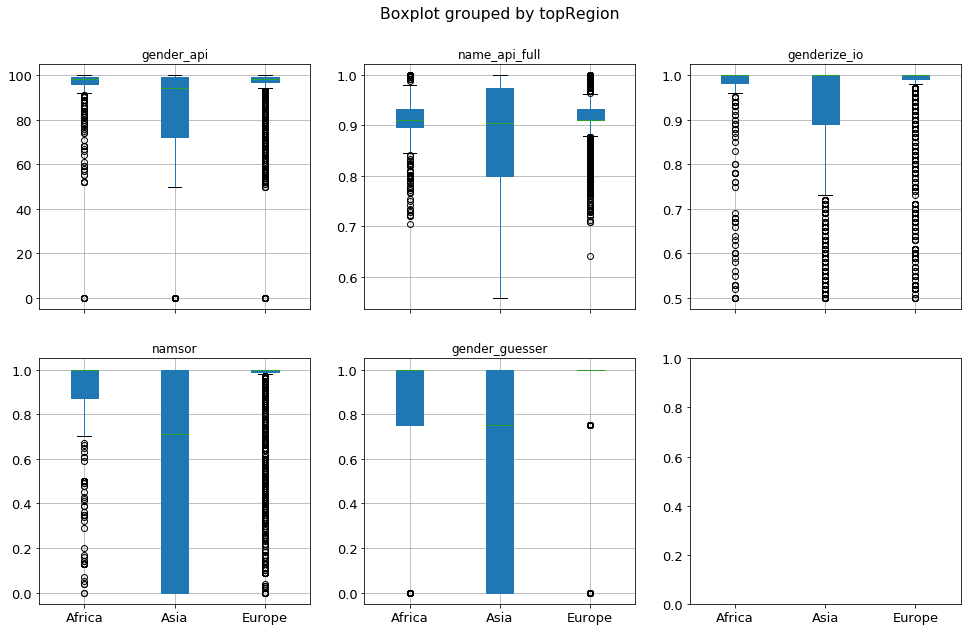

In [23]:
# Compute mean and standard deviation of each service depending on the region
accuracy_param_per_service = {
    'gender_api': 'api_accuracy',
    'genderize_io': 'api_probability',
    'namsor': 'api_scale',
    'name_api_full': 'api_confidence',
    'gender_guesser': 'api_confidence'
}

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16,10), sharex=True)
#fig.suptitle('bold figure suptitle', fontsize=14, fontweight='bold')
counter = 0
for s in [GenderAPIEvaluator, NameAPIFullEvaluator, GenderizeIoEvaluator, NamSorEvaluator, GenderGuesserEvaluator]:  
    evaluator = s('all')
    eval_name = evaluator.gender_evaluator
    evaluator.load_data(evaluated=True)
    # add onomastic information and restrict to rows with reliable onomastic class
    evaluator.test_data['topRegion'] = origin_df['topRegion']
    evaluator.test_data['score_origin'] = origin_df['score_origin']
    evaluator.test_data = evaluator.test_data[evaluator.test_data['score_origin']>0]
    evaluator.preprocess_tuning_params()
    accuracy_param = accuracy_param_per_service[eval_name]
    row_index, col_index = divmod(counter, 3)
    # for plausibility test print a few lines and numbers
    #print (eval_name)
    #print(evaluator.test_data[['full_name', 'topRegion', accuracy_param]].sample(3, random_state=1))
    # plot; see http://blog.bharatbhole.com/creating-boxplots-with-matplotlib/ for tweaking the appearance
    
    evaluator.test_data.boxplot(column=accuracy_param, by='topRegion', ax=ax[row_index, col_index], patch_artist=True)
    ax[row_index, col_index].set_title(eval_name, fontsize=12)
    ax[row_index, col_index].set_xlabel('')
    ax[row_index, col_index].set_xticklabels(ax[row_index, col_index].get_xticklabels(),rotation=0)
    # TODO: rename services using dictionary gender_evalautor_to_service_name

    counter +=1
    
    
    #fig.delaxes(ax[2,1])
    
plt.savefig('../../../benchmark_paper/resubmission/accuracy_by_top_region.pdf', bbox_inches = 'tight')

**The boxplots for the mean and deviation of the api confidence w.r.t to different top regions show that:** 

* all services except Name API show the highest confidence for gender inference for names of European origin: here the median is at (almost) the highest possible value and the deviation is very low. 
* all services have the largest interquartile range for names of Asian origin, which implies that for Asia, the quality of the name-based gender inference variies depending on the subregion or country. However, gender API and genderize_io have a significantly higher median and a lower deviation for Asian names than gender_guesser or Namsor. 
* genderize_io shows a suspiciously high confidence for Asian names.

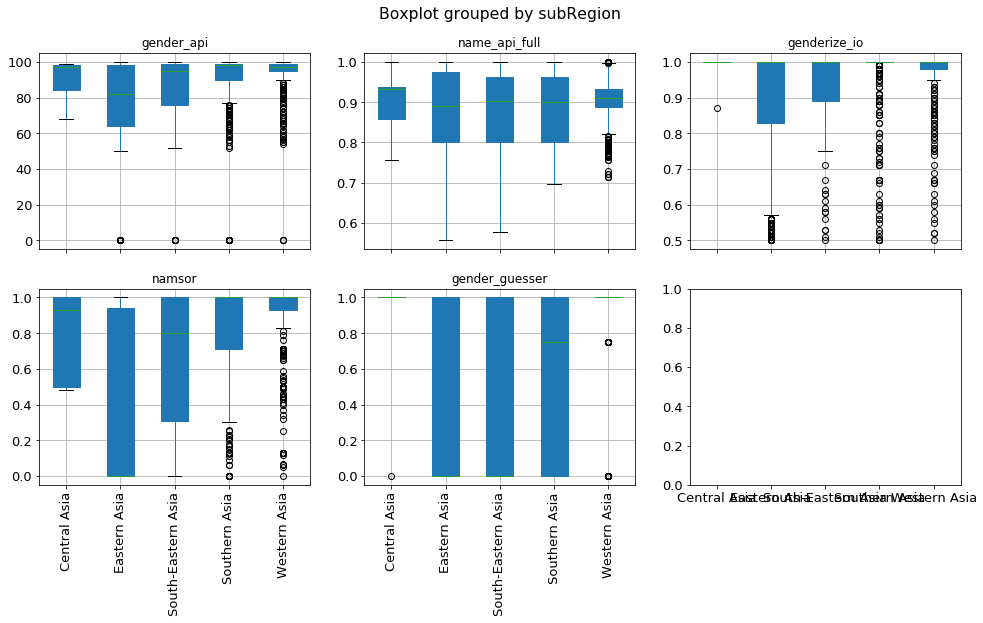

In [25]:
# Compute mean and standard deviation of each service depending on the sub region with topRegion=Asia
accuracy_param_per_service = {
    'gender_api': 'api_accuracy',
    'genderize_io': 'api_probability',
    'namsor': 'api_scale',
    'name_api_full': 'api_confidence',
    'gender_guesser': 'api_confidence'
}

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16,8), sharex=True)
#fig.suptitle('bold figure suptitle', fontsize=14, fontweight='bold')
counter = 0
for s in [GenderAPIEvaluator, NameAPIFullEvaluator, GenderizeIoEvaluator, NamSorEvaluator, GenderGuesserEvaluator]:  
    evaluator = s('all')
    eval_name = evaluator.gender_evaluator
    evaluator.load_data(evaluated=True)
    # add onomastic information and restrict to rows with reliable onomastic class
    evaluator.test_data['topRegion'] = origin_df['topRegion']
    evaluator.test_data['subRegion'] = origin_df['subRegion']
    evaluator.test_data['score_origin'] = origin_df['score_origin']
    evaluator.test_data = evaluator.test_data[evaluator.test_data['score_origin']>0]
    evaluator.test_data = evaluator.test_data[evaluator.test_data['topRegion']=='Asia']
    evaluator.preprocess_tuning_params()
    accuracy_param = accuracy_param_per_service[eval_name]
    row_index, col_index = divmod(counter, 3)
    # plot; see http://blog.bharatbhole.com/creating-boxplots-with-matplotlib/ for tweaking the appearance
    evaluator.test_data.boxplot(column=accuracy_param, by='subRegion', ax=ax[row_index, col_index], 
                                patch_artist=True)
    ax[row_index, col_index].set_title(eval_name, fontsize=12)
    ax[row_index, col_index].set_xlabel('')
    ax[row_index, col_index].set_xticklabels(ax[row_index, col_index].get_xticklabels(),rotation=90)
    counter +=1
#fig.tight_layout()

plt.savefig('../../../benchmark_paper/resubmission/accuracy_by_subregion_asia.pdf', bbox_inches = 'tight')

* genderize_io shows, as seen before, a too high mean for all Asian regions but std is higher for Eastern and South Eastern Asia
* All services struggle most with East Asia but e.g. gender_api has stil mean above 80 for East Asia and Namsor has almost 0 (similar to gender_guesser) 
* Name API: similar confidence for all Asian subRegions
* gender_guesser: mean = 0 for Eastern and South-Eastern Asia, higher for Southern Asia and high (=1) for Central and Western Asia


In [54]:
def compute_all_errors_without_tuning(name_origin, origin_level):
    """'origin_level' specifies the level within the onomastic class, and should be one of 
    'topRegion', 'subRegion' and 'country'. THe variable 'name_origin' is the value of the onomastic class, e.g.
    'Ireland' in origin_level is country."""
    service_to_all_errors = {}
    error_names = ['errorCoded', 'errorCodedWithoutNA', 'errorGenderBias', 'naCoded', 'WeightedError']
    
    for s in REGISTERED_EVALUATORS:  
        evaluator = s('all')
        eval_name = evaluator.gender_evaluator
        evaluator.load_data(evaluated=True)
        # add onomastic information and restrict to rows with reliable onomastic class
        evaluator.test_data['topRegion'] = origin_df['topRegion']
        evaluator.test_data['subRegion'] = origin_df['subRegion']
        evaluator.test_data['country'] = origin_df['country']
        evaluator.test_data['score_origin'] = origin_df['score_origin']
        evaluator.test_data = evaluator.test_data[evaluator.test_data['score_origin']>0]
        # compute errors per name origin
        evaluator.test_data = evaluator.test_data[evaluator.test_data[origin_level]==name_origin].reset_index(drop=True)
        evaluator._translate_api_response()
        evaluator.compute_confusion_matrix(evaluator.test_data)
        errors = evaluator.compute_all_errors()
        service_to_all_errors[eval_name] = errors
    all_errors = pd.DataFrame.from_dict(service_to_all_errors, orient='index')
    all_errors.columns = error_names
    return all_errors

In [57]:
import seaborn as sns
sns.set(color_codes=True)

In [58]:
# Benchmark 1 for topRegion Africa
cm = sns.light_palette("green", as_cmap=True)
df = compute_all_errors_without_tuning(name_origin='Africa', origin_level='topRegion')
df = reduce_table(df, by_index=True)
df = df.round(3)

df.style.background_gradient(cmap=cm)

,errorCoded,errorCodedWithoutNA,errorGenderBias,naCoded,WeightedError
NameAPI,0.151,0.04,0.024,0.115,0.065
Gender API,0.054,0.047,-0.011,0.007,0.048
genderize.io,0.104,0.053,0.03,0.054,0.064
NamSor,0.065,0.044,0,0.022,0.048
gender-guesser,0.244,0.037,-0.009,0.215,0.087


In [59]:
df.columns

Index(['errorCoded', 'errorCodedWithoutNA', 'errorGenderBias', 'naCoded',
       'WeightedError'],
      dtype='object')

### Name origin level: `topRegion`

In [60]:
top_regions = origin_df[origin_df.score_origin>0]['topRegion'].unique()
top_regions

array(['Europe', 'Asia', 'Africa'], dtype=object)

In [61]:
top_region_to_errors = {}
for item in top_regions:
    df = compute_all_errors_without_tuning(name_origin=item, origin_level='topRegion')
    df = reduce_table(df, by_index=True)
    df = df.round(3)
    top_region_to_errors[item] = df

In [62]:
top_region_to_errors['Asia'].style.background_gradient(cmap=cm)

,errorCoded,errorCodedWithoutNA,errorGenderBias,naCoded,WeightedError
NameAPI,0.377,0.09,0.019,0.316,0.167
Gender API,0.176,0.112,-0.01,0.072,0.126
genderize.io,0.328,0.121,0.053,0.236,0.172
NamSor,0.346,0.09,0.033,0.281,0.156
gender-guesser,0.517,0.064,0.014,0.484,0.212


### Name origin level: `subRegion`

In [63]:
sub_regions = origin_df[origin_df.score_origin>0]['subRegion'].unique()
sub_regions

array(['Western Europe', 'Southern Europe', 'Eastern Asia',
       'Southern Asia', 'Northern Europe', 'Eastern Europe',
       'Western Asia', 'Western Africa', 'Northern Africa',
       'Eastern Africa', 'Southern Africa', 'South-Eastern Asia',
       'Middle Africa', 'Central Asia'], dtype=object)

In [64]:
sub_region_to_errors = {}
for item in sub_regions:
    df = compute_all_errors_without_tuning(name_origin=item, origin_level='subRegion')
    df = reduce_table(df, by_index=True)
    df = df.round(3)
    sub_region_to_errors[item] = df

In [65]:
sub_region_to_errors['Eastern Europe'].style.background_gradient(cmap=cm)

,errorCoded,errorCodedWithoutNA,errorGenderBias,naCoded,WeightedError
NameAPI,0.067,0.013,0,0.055,0.024
Gender API,0.021,0.015,-0.015,0.006,0.017
genderize.io,0.08,0.029,0.01,0.052,0.04
NamSor,0.021,0.012,0,0.009,0.014
gender-guesser,0.113,0.017,-0.01,0.098,0.038


In [66]:

dfs_top_region = pd.concat(OrderedDict(top_region_to_errors.items()).values(), axis=1, 
                           keys=OrderedDict(top_region_to_errors.items()).keys())
dfs_top_region 

Africa                                              \
               errorCoded errorCodedWithoutNA errorGenderBias naCoded   
NameAPI             0.151               0.040           0.024   0.115   
Gender API          0.054               0.047          -0.011   0.007   
genderize.io        0.104               0.053           0.030   0.054   
NamSor              0.065               0.044           0.000   0.022   
gender-guesser      0.244               0.037          -0.009   0.215   

                                 Europe                                      \
               WeightedError errorCoded errorCodedWithoutNA errorGenderBias   
NameAPI                0.065      0.081               0.014          -0.002   
Gender API             0.048      0.028               0.021          -0.012   
genderize.io           0.064      0.051               0.022           0.010   
NamSor                 0.048      0.027               0.021          -0.002   
gender-guesser         0.087      0.075               0.015           0.000   

                                           Asia                      \
               naCoded WeightedError errorCoded errorCodedWithoutNA   
NameAPI          0.068         0.028      0.377               0.090   
Gender API       0.007         0.023      0.176               0.112   
genderize.io     0.029         0.028      0.328               0.121   
NamSor           0.006         0.022      0.346               0.090   
gender-guesser   0.061         0.027      0.517               0.064   

                                                      
               errorGenderBias naCoded WeightedError  
NameAPI                  0.019   0.316         0.167  
Gender API              -0.010   0.072         0.126  
genderize.io             0.053   0.236         0.172  
NamSor                   0.033   0.281         0.156  
gender-guesser           0.014   0.484         0.212

In [67]:
dfs_top_region.columns = dfs_top_region.columns.swaplevel(0, 1)
dfs_top_region.sortlevel(0, axis=1, inplace=True)
dfs_top_region

/Users/helena.mihaljevic-br/.virtualenvs/name-based-inference/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  


WeightedError               errorCoded                \
                      Africa   Asia Europe     Africa   Asia Europe   
NameAPI                0.065  0.167  0.028      0.151  0.377  0.081   
Gender API             0.048  0.126  0.023      0.054  0.176  0.028   
genderize.io           0.064  0.172  0.028      0.104  0.328  0.051   
NamSor                 0.048  0.156  0.022      0.065  0.346  0.027   
gender-guesser         0.087  0.212  0.027      0.244  0.517  0.075   

               errorCodedWithoutNA               errorGenderBias         \
                            Africa   Asia Europe          Africa   Asia   
NameAPI                      0.040  0.090  0.014           0.024  0.019   
Gender API                   0.047  0.112  0.021          -0.011 -0.010   
genderize.io                 0.053  0.121  0.022           0.030  0.053   
NamSor                       0.044  0.090  0.021           0.000  0.033   
gender-guesser               0.037  0.064  0.015          -0.009  0.014   

                      naCoded                
               Europe  Africa   Asia Europe  
NameAPI        -0.002   0.115  0.316  0.068  
Gender API     -0.012   0.007  0.072  0.007  
genderize.io    0.010   0.054  0.236  0.029  
NamSor         -0.002   0.022  0.281  0.006  
gender-guesser  0.000   0.215  0.484  0.061

In [68]:
# Reorder columns
dfs_top_region = dfs_top_region[dfs_top_region.columns.set_levels(['errorCoded', 'errorCodedWithoutNA', 
                                                                   'errorGenderBias', 'naCoded','WeightedError'], 
                                                                  level=0)]

In [69]:
dfs_top_region.style.set_table_styles([dict(selector="th", 
                                            props=[('max-width', '150px')])]).background_gradient(cmap=cm)

* Here we see that `genderize_io` performs very poorly in terms of the `errorCoderWithoutNA` on names of Asian origin, showing the highest error rate among all five services. This was already indicated by the boxplots showing the mean and average confidence for Asian names: in contrast to the other services, `genderize_io` had very high confidence values for Asian names, despite the fact that it is very hard to infer the gender from many Asian names, in particular those from China.
* For European names, `gender_api` and `namsor` show basically the same error rates except for `errorGenderBias` for which `namsor` performs better. For metrics tha take into account the recall (`errorCoded` and `naCoded`), these two services perform best for European names; for metrics that aim to reduce the number of misclassifications between men and women, `name_api` and `gender_guesser` are more suitable.
* `gender_guesser` shows basically the least `errorCoderWithoutNA` values for all three regions, as was expected due to the manual curation of the data set. The downside is, however, that it performs very poorly in terms of the metrics `errorCoded` or `naCoded` that also measure the number of names classified as unknown.
* In terms of the `weightedError`, which weights the mix ups between women and men five times more than classifying as unknown, we see that `gender_api` and `namsor` are both equally good for Africa and Europe; for Asia however, `gender_api` is a clear winnen and `namsor` is on place 2.

In [71]:
from string import ascii_uppercase

# Color codes for tables
light_green = '#e5ffe5'
dark_green = '#2e992e'
# add colors using ExcelWriter; see http://xlsxwriter.readthedocs.io/working_with_conditional_formats.html
file_path = '../../../benchmark_paper/resubmission/table_benchmark_1_by_top_region.xlsx'
writer = pd.ExcelWriter(file_path, engine='xlsxwriter')
dfs_top_region.to_excel(writer, sheet_name='Sheet1')
workbook  = writer.book
worksheet = writer.sheets['Sheet1']

for letter in ascii_uppercase:
    worksheet.conditional_format(letter+'2:' + letter +'8', {'type': '2_color_scale', 'min_color': light_green, 
                                                             'max_color': dark_green})

writer.save()
